# Double-descent phenomena on Random Forest
The double descent risk curve, a phenomenon where test error first gets better, then worse, and then gets better again,  is one of the most interesting phenomena in understanding and analyzing modern machine learning. 

We provide an example where ensembles of either shallow or deep trees can achieve Bayes optimal performance, but only the ensemble of deep trees exhibit the double descent phenomenon.  This is because when the trees are deep, more trees (parameters) are essentially only smoothing, whereas when the trees are shallow, more trees (parameters) are both smoothing and adding capacity. 

*Let's first import the necessary packages and modules*

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn import metrics
from sklearn import tree
from tqdm import tqdm

from sklearn.metrics import log_loss

The experimental setup is as follows. We generate a two-dimensional Gaussian XOR dataset as a benchmark with four spherically symmetric Gaussians.  Class one has two Gaussians with centers (-1,-1) and (1,1), whereas the other class has two Gaussians with means (1,-1) and (-1,1). There will be 5096 random samples from the two classes, which will be split into 4096 training samples and 1000 testing samples.

*Here, we define the function to generate the Gaussian XOR samples.*


In [ ]:
def generate_gaussian_parity(n, cov_scale=1, angle_params=None, k=1, acorn=None):
    means = [[-1, -1], [1, 1], [1, -1], [-1, 1]]
    blob = np.concatenate(
        [
            np.random.multivariate_normal(
                mean, cov_scale * np.eye(len(mean)), size=int(n / 4)
            )
            for mean in means
        ]
    )

    X = np.zeros_like(blob)
    Y = np.concatenate([np.ones((int(n / 4))) * int(i < 2) for i in range(len(means))])
    X[:, 0] = blob[:, 0] * np.cos(angle_params * np.pi / 180) + blob[:, 1] * np.sin(
        angle_params * np.pi / 180
    )
    X[:, 1] = -blob[:, 0] * np.sin(angle_params * np.pi / 180) + blob[:, 1] * np.cos(
        angle_params * np.pi / 180
    )
    return X, Y.astype(int)

 *Let us visualize the Gaussian XOR dataset.*

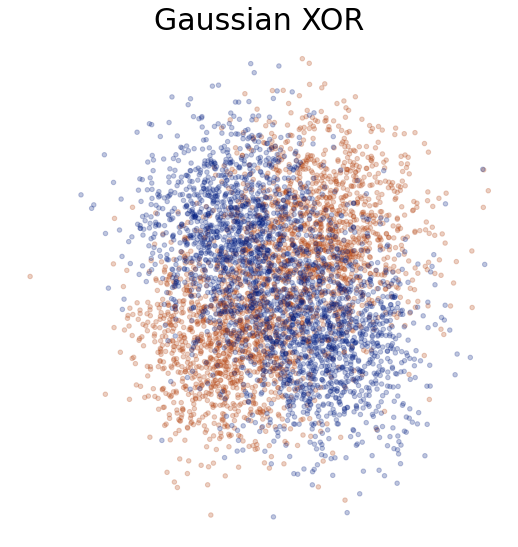

In [ ]:
import seaborn as sns
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def plot_xor(data, labels, title):
    colors = sns.color_palette("dark", n_colors=2)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.scatter(data[:, 0], data[:, 1], c=get_colors(colors, labels), s=20, alpha=0.25)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=30)
    plt.tight_layout()
    ax.axis("off")
    ax.set_position([0, 0, 1, 1])
    # plt.savefig('gaussian_xor.svg', bbox_inches='tight', transparent=True)
    plt.show()
    
X_test, y_test = generate_gaussian_parity(n=5096, angle_params=0)
plot_xor(X_test, y_test, 'Gaussian XOR')

*Since we will work on Random Forest and Gradient Boosting, we will define a function called ```get_tree``` to get an instance of either one of the models with a given set of parameters.*

 

In [ ]:
def get_tree(method='rf', max_depth=1, n_estimators=1, max_leaf_nodes = None ):
  if method == 'gb':
    rf = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=1514, max_leaf_nodes=max_leaf_nodes, learning_rate=1, criterion='mse')
  else:
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=1514, max_leaf_nodes=max_leaf_nodes)
  return rf


*Now, we introduce a helper function ```gini_impurity_mean``` that will be used to calculate a Gini impurity of the algorthms.*

In [ ]:
def gini_impurity(P1=0, P2=0):
  denom = P1 + P2
  Ginx = 2 * (P1/denom) * (P2/denom)
  return(Ginx)
def gini_impurity_mean(rf, data, label):
  leaf_idxs = rf.apply(data)

  predict = label
  gini_mean_score = []

  for t in range(leaf_idxs.shape[1]):
    gini_arr = []
    for l in np.unique(leaf_idxs[:,t]):
      cur_l_idx = predict[leaf_idxs[:,t]==l]
      pos_count = np.sum(cur_l_idx)
      neg_count = len(cur_l_idx) - pos_count
      gini = gini_impurity(pos_count, neg_count)
      gini_arr.append(gini) 

    gini_mean_score.append(np.array(gini_arr).mean())
  return np.array(gini_mean_score).mean()

*Here we will compute the estimated optimal bayes error using HP divergence from the ```smartsvm``` package.*

In [ ]:
# Optimal Bayes Error
from smartsvm import hp_estimate, compute_error_graph
import numpy as np
bayes_errors = []
for _ in range(1000):
  X_train, y_train = generate_gaussian_parity(n=4096, angle_params=0)
  X_test, y_test = generate_gaussian_parity(n=1000, angle_params=0)
  optimal_err = hp_estimate(X_test[y_test==0], X_test[y_test==1], normalize=False)
  bayes_errors.append(optimal_err) 
  # G = compute_error_graph(X_test, y_test)
print('Bayes Optimal Error: ', np.array(bayes_errors).mean() )

*This is the main function we can call for an experiment of decision forests with shallow and deep trees.*

In [ ]:
def rf_dd_exp(N=4096, iterations=100, max_node=None, n_est=10):
  # lists to store the average error and gini scores
  train_mean_error, test_mean_error = [], []
  train_mean_error_log, test_mean_error_log = [], []
  gini_train_mean_score, gini_test_mean_score = [], []

  # draw the training and test samples 
  X_train, y_train = generate_gaussian_parity(n=N, angle_params=0)
  X_test, y_test = generate_gaussian_parity(n=N, angle_params=0)

  # set 'rf' for Random Forest and 'gb' for Gradient Boosting
  method = 'rf'    

  # if max node is None, we set it to the estimate of max nodes to overfit the training  
  if max_node is None:
    rf = get_tree(method, max_depth=None)
    rf.fit(X_train, y_train)
    if method == 'gb':
      max_node = (sum([estimator[0].get_n_leaves() for estimator in rf.estimators_])) + 50
    else:
      max_node = sum([estimator.get_n_leaves() for estimator in rf.estimators_]) +50
  
  train_error, test_error  = [list() for _ in range(iterations)], [list() for _ in range(iterations)]
  train_error_log, test_error_log  = [list() for _ in range(iterations)], [list() for _ in range(iterations)]
  gini_score_train, gini_score_test = [list() for _ in range(iterations)], [list() for _ in range(iterations)]
  nodes = [list() for _ in range(iterations)]

  for iter_i in tqdm(range(iterations), position=0, leave=True):
      ## uncomment if you want to draw new samples for every iterations  
      # X_train, y_train = generate_gaussian_parity(n=N, angle_params=0)
      # X_test, y_test = generate_gaussian_parity(n=1000, angle_params=0)
      
      # we start with a single tree of depth 1
      rf = get_tree(method, max_depth=1)

      for depth in (range(1, max_node + n_est)):

          if depth < max_node:
            rf.max_depth += 1
          else:
            rf.n_estimators += 3
            # rf.max_depth += 10
          
          rf.fit(X_train, y_train)

          # if x-axis is number of leaf nodes
          if method == 'gb':
            nodes[iter_i].append(sum([(estimator[0].get_n_leaves()) for estimator in rf.estimators_])) 
          else:
            nodes[iter_i].append(sum([estimator.get_n_leaves() for estimator in rf.estimators_]))
          
          ## uncomment if x-axis is number of polytopes
          # leaf_idxs = rf.apply(X_train)
          # nodes[iter_i].append(len(np.unique(leaf_idxs))) 

          gini_score_train[iter_i].append(gini_impurity_mean(rf, X_train, y_train))
          gini_score_test[iter_i].append(gini_impurity_mean(rf, X_test, y_test))
          train_error[iter_i].append(1 - rf.score(X_train, y_train))
          test_error[iter_i].append(1 - rf.score(X_test, y_test))
          train_error_log[iter_i].append(log_loss(y_train, rf.predict(X_train)))
          test_error_log[iter_i].append(log_loss(y_test, rf.predict(X_test)))
          
      nodes[iter_i] = np.array(nodes[iter_i])
      train_error[iter_i] = np.array(train_error[iter_i])
      test_error[iter_i] = np.array(test_error[iter_i])
      train_error_log[iter_i] = np.array(train_error_log[iter_i])
      test_error_log[iter_i] = np.array(test_error_log[iter_i])
      gini_score_train[iter_i] = np.array(gini_score_train[iter_i])
      gini_score_test[iter_i] = np.array(gini_score_test[iter_i])

  train_mean_error = np.array(train_error).mean(axis=0)
  test_mean_error = np.array(test_error).mean(axis=0)
  train_mean_error_log = np.array(train_error_log).mean(axis=0)
  test_mean_error_log = np.array(test_error_log).mean(axis=0)
  nodes_mean = np.array(nodes).mean(axis=0)
  gini_train_mean_score = np.array(gini_score_train).mean(axis=0)
  gini_test_mean_score = np.array(gini_score_test).mean(axis=0)
  
  error_dict = {'train_err': train_mean_error, 
                'test_err': test_mean_error,
                'train_err_log': train_mean_error_log,
                'test_err_log': test_mean_error_log,
                'train_gini': gini_train_mean_score,
                'test_gini': gini_test_mean_score,
                'nodes': nodes_mean}
  return error_dict

*Run the two experiments: one with deep trees and the other with shallow trees.*

In [ ]:
iterations = 100 # the number of repetitions of a single run of the algorithm
# Run DeepRF
error_dd = rf_dd_exp(iterations=iterations)
# Run ShallowRF
error_5 = rf_dd_exp(max_node=15, n_est=100, iterations=iterations)
# np.save('errors.npy', [error_5, error_dd])

 56%|█████▌    | 56/100 [28:01<22:19, 30.44s/it]

In [ ]:
# [error_5, error_dd] = np.load('errors.npy', allow_pickle=True)

*Visualize the generalization error and gini impurity of both decision tree variants.*

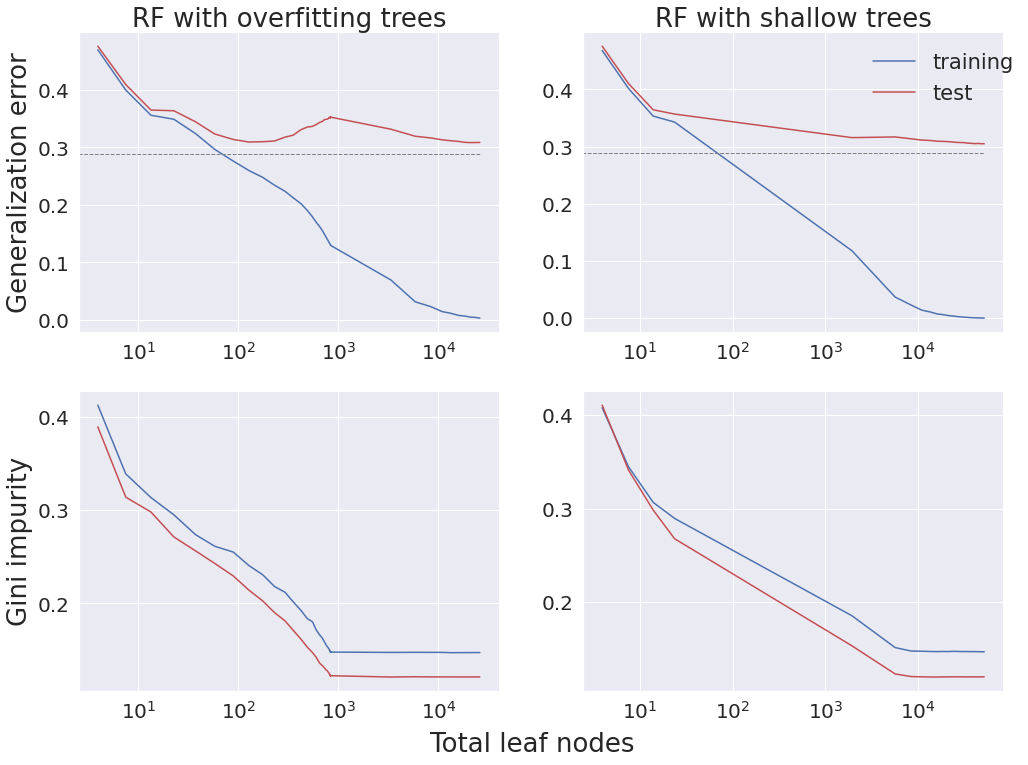

In [ ]:
import seaborn as sns
sns.set()
sns.color_palette()

##Figure params
fontsize = 26
ticksize = 20
plt.figure(figsize=(14,10))
plt.tick_params(labelsize=ticksize)
plt.tight_layout()

# Misclassification Error
plt.subplot(2, 2, 1)
plt.plot(error_dd['nodes'], error_dd['train_err'], label="training")
plt.plot(error_dd['nodes'], error_dd['test_err'], '-r', label="test")
plt.xscale("log")
plt.ylabel('Generalization error', fontsize=fontsize)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.plot([0, np.max(error_dd['nodes'])], [0.289, 0.289], '--', color='gray', linewidth=1, label='optimal bayes error')
plt.title('RF with overfitting trees', fontsize=fontsize)

plt.subplot(2, 2, 2)
plt.plot((error_5['nodes']), error_5['train_err'], label="training")
plt.plot((error_5['nodes']), error_5['test_err'], '-r', label="test")
plt.xscale("log")
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.plot([0, np.max(error_5['nodes'])], [0.289, 0.289], '--', color='gray', linewidth=1, label='optimal bayes error')
plt.title('RF with shallow trees', fontsize=fontsize)

# Gini Impurity 
plt.subplot(2, 2, 3)
plt.plot((error_dd['nodes']), error_dd['train_gini'], label="training")
plt.plot((error_dd['nodes']), error_dd['test_gini'], '-r', label="test")
plt.xscale("log")
plt.ylabel('Gini impurity', fontsize=fontsize)
plt.locator_params(axis='y', nbins=6.5)
plt.tick_params(axis='both', which='major', labelsize=ticksize)

plt.subplot(2, 2, 4)
plt.plot((error_5['nodes']), error_5['train_gini'], label="training")
plt.plot((error_5['nodes']), error_5['test_gini'], '-r', label="test")
plt.xscale("log")
plt.locator_params(axis='y', nbins=6.5)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
ax = plt.gca()
lines, labels = ax.get_legend_handles_labels()    
plt.legend( lines, labels, loc = 'best', bbox_to_anchor = (0.0,-0.03,1,1),
            bbox_transform = plt.gcf().transFigure , fontsize=fontsize-5, frameon=False)

plt.text(0.7, 0.04, 'Total leaf nodes', ha='center', fontsize=fontsize)

sns.despine();
plt.savefig('RF_dd.pdf', bbox_inches='tight')
plt.show()

## Discussion
In the top row, the figure shows classification error versus the total number of leaf nodes. In the RF algorithm with deep trees (left panels), a single decision tree is grown until each leaf node is pure, and then more trees are added with similar complexity as the first tree. These deep RFs exhibit the double-descent phenomenon, just like deep learning methods: as the number of leaf nodes increases, first test error drops, then it increases as it overfits, and then it drops again as more trees are included. On the other hand, consider the RF algorithm with shallow trees (right panels), that starts with a single tree increasing the number of its leaf nodes until it achieves a maximum depth of five, and then increases the number of trees, all of which having maximum depth five. These shallow RFs exhibit the classical monotonically decreasing out of sample error rates.  Notably, both algorithms demonstrate monotonically decreasing training error, and eventually both achieve Bayes optimal performance on the test data. 
